# SPA detection post-processing

## Import packages

In [1]:
import lmfit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import sem
import seaborn as sns
from tqdm import tqdm

plt.style.use(['seaborn-dark', 'notebook'])

## Signal size and linewidth for different R-branch transitions

### Load data

In [2]:
def load_data(fname: str, n_gamma: float = 1.) -> pd.DataFrame:
    """
    Loads data from csv and makes some new columns.
    """
    df =  pd.read_csv(fname, skiprows = 2)
    column_names = ['laser_detuning', 'n_photons', 'n_photons_sem']
    mapper = {old_name:new_name for old_name, new_name in zip(df.columns,column_names)}
    df.rename(columns = mapper, inplace = True)
    df['detuning_MHz'] = df.laser_detuning/(2*np.pi*1e6)
    
    df['norm_signal'] = df['n_photons']/n_gamma
    df['norm_signal_sem'] = df['n_photons_sem']/n_gamma
    
    return df


In [3]:
df_R0F2 = load_data("./saved_data/R(0),_F'=2_bs_agg_n_traj=100_n_bs=100_2022-05-24_18-15-49.csv", n_gamma = 1.92)
df_R1F3 = load_data("./saved_data/R(1)_F'=3_bs_agg_n_traj=100_n_bs=100_2022-05-24_20-48-39.csv", n_gamma = 2.1)
df_R2F4 = load_data("./saved_data/R(2)_F'=4_bs_agg_n_traj=100_n_bs=100_2022-05-25_00-47-42.csv", n_gamma = 2.13)

# df_R0F2 = load_data("./saved_data/R(0),_F'=2_bs_agg_n_traj=100_n_bs=100_2022-05-24_18-15-49.csv", n_gamma = .904)
# df_R1F3 = load_data("./saved_data/R(1)_F'=3_bs_agg_n_traj=100_n_bs=100_2022-05-24_20-48-39.csv", n_gamma = .970)
# df_R2F4 = load_data("./saved_data/R(2)_F'=4_bs_agg_n_traj=100_n_bs=100_2022-05-25_00-47-42.csv", n_gamma = .955)

Numbers of photons at resonance:
R(0), F' = 2: 0.906
R(1), F' = 3: 0.970
R(2), F' = 4: 0.955


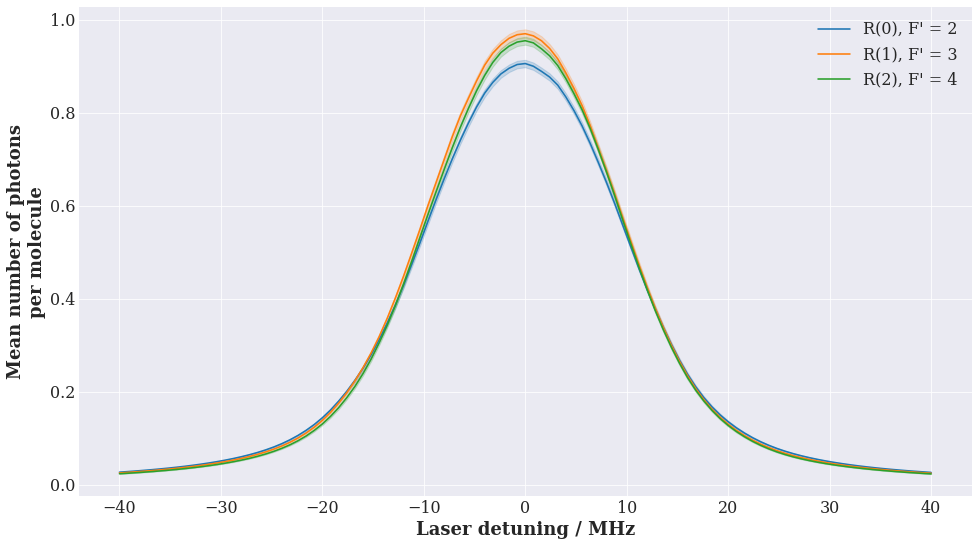

In [4]:
fig, ax = plt.subplots()
ax.plot(df_R0F2.detuning_MHz, df_R0F2.n_photons, color = 'C0', label = "R(0), F' = 2")
ax.fill_between(df_R0F2.detuning_MHz, df_R0F2.n_photons-df_R0F2.n_photons_sem, df_R0F2.n_photons+df_R0F2.n_photons_sem, color = 'C0', alpha = 0.2)
ax.plot(df_R1F3.detuning_MHz, df_R1F3.n_photons, color = 'C1', label = "R(1), F' = 3")
ax.fill_between(df_R1F3.detuning_MHz, df_R1F3.n_photons-df_R1F3.n_photons_sem, df_R1F3.n_photons+df_R1F3.n_photons_sem, color = 'C1', alpha = 0.2)
ax.plot(df_R2F4.detuning_MHz, df_R2F4.n_photons, color = 'C2', label = "R(2), F' = 4")
ax.fill_between(df_R2F4.detuning_MHz, df_R2F4.n_photons-df_R2F4.n_photons_sem, df_R2F4.n_photons+df_R2F4.n_photons_sem, color = 'C2', alpha = 0.2)
ax.set_xlabel('Laser detuning / MHz')
ax.set_ylabel('Mean number of photons\nper molecule')
ax.legend()
print("Numbers of photons at resonance:")
print(f"R(0), F' = 2: {df_R0F2.n_photons.max():.3f}")
print(f"R(1), F' = 3: {df_R1F3.n_photons.max():.3f}")
print(f"R(2), F' = 4: {df_R2F4.n_photons.max():.3f}")

Maximum normalized signal sizes:
R(0), F' = 2: 0.472
R(1), F' = 3: 0.462
R(2), F' = 4: 0.448


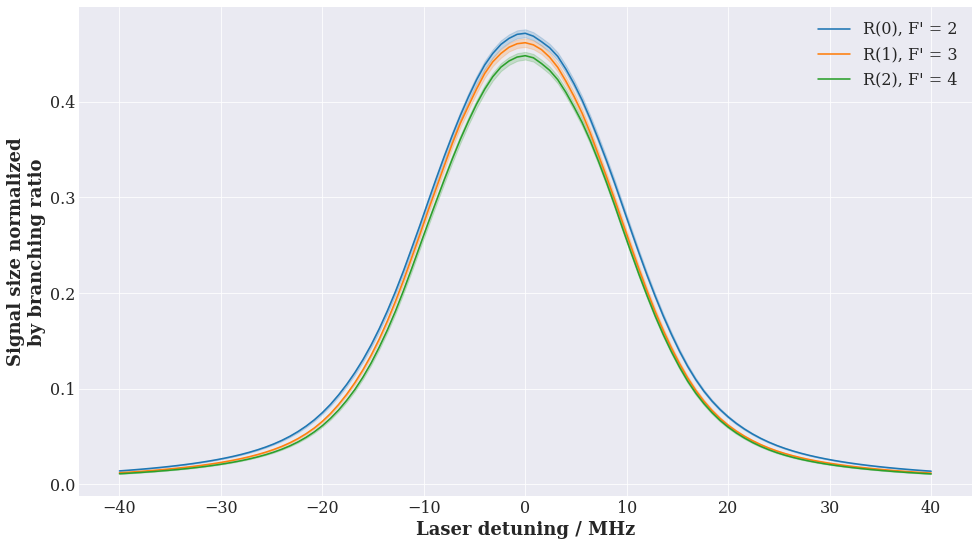

In [46]:
fig, ax = plt.subplots()
ax.plot(df_R0F2.detuning_MHz, df_R0F2.norm_signal, color = 'C0', label = "R(0), F' = 2")
ax.fill_between(df_R0F2.detuning_MHz, df_R0F2.norm_signal-df_R0F2.norm_signal_sem, df_R0F2.norm_signal+df_R0F2.norm_signal_sem, color = 'C0', alpha = 0.2)
ax.plot(df_R1F3.detuning_MHz, df_R1F3.norm_signal, color = 'C1', label = "R(1), F' = 3")
ax.fill_between(df_R1F3.detuning_MHz, df_R1F3.norm_signal-df_R1F3.norm_signal_sem, df_R1F3.norm_signal+df_R1F3.norm_signal_sem, color = 'C1', alpha = 0.2)
ax.plot(df_R2F4.detuning_MHz, df_R2F4.norm_signal, color = 'C2', label = "R(2), F' = 4")
ax.fill_between(df_R2F4.detuning_MHz, df_R2F4.norm_signal-df_R2F4.norm_signal_sem, df_R2F4.norm_signal+df_R2F4.norm_signal_sem, color = 'C2', alpha = 0.2)
ax.set_xlabel('Laser detuning / MHz')
ax.set_ylabel('Signal size normalized\nby branching ratio')
ax.legend()

print("Maximum normalized signal sizes:")
print(f"R(0), F' = 2: {df_R0F2.norm_signal.max():.3f}")
print(f"R(1), F' = 3: {df_R1F3.norm_signal.max():.3f}")
print(f"R(2), F' = 4: {df_R2F4.norm_signal.max():.3f}")

### What is the lineshape?
Try fitting a Voigt-lineshape to the simulated data to see if it matches well

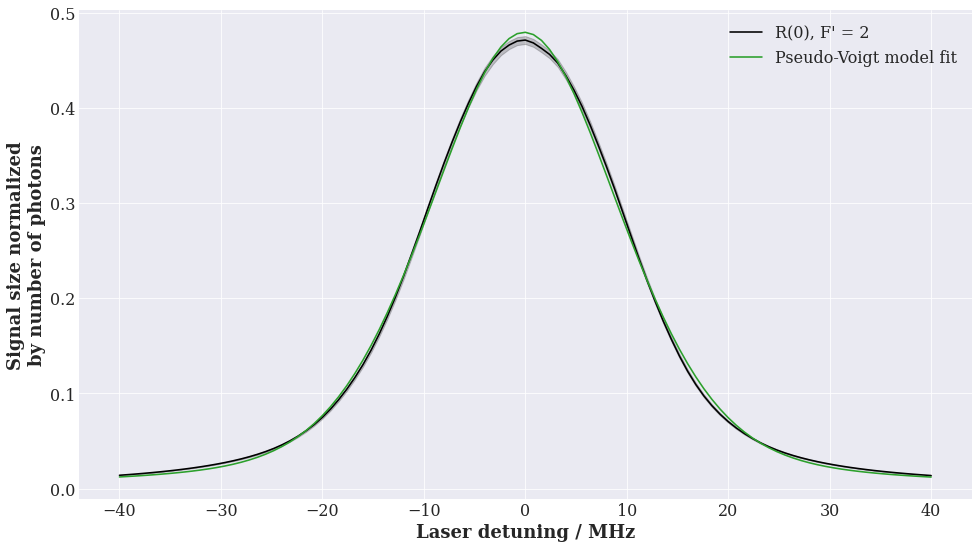

In [6]:
fig, ax = plt.subplots()

# Plot data
ax.plot(df_R0F2.detuning_MHz, df_R0F2.norm_signal, color = 'k', label = "R(0), F' = 2")
ax.fill_between(df_R0F2.detuning_MHz, df_R0F2.norm_signal-df_R0F2.norm_signal_sem, df_R0F2.norm_signal+df_R0F2.norm_signal_sem, color = 'k', alpha = 0.2)

# # Fit and plot model
# model = lmfit.models.DampedOscillatorModel()
# params = model.guess(df_R0F2.norm_signal, x = df_R0F2.detuning_MHz)
# fit_result = model.fit(df_R0F2.norm_signal, x = df_R0F2.detuning_MHz, params = params)
# ax.plot(df_R0F2.detuning_MHz, fit_result.best_fit, color = 'C1', label = "Model fit")

# # Fit and plot model
# model = lmfit.models.VoigtModel()
# params = model.guess(df_R0F2.norm_signal, x = df_R0F2.detuning_MHz)
# fit_result = model.fit(df_R0F2.norm_signal, x = df_R0F2.detuning_MHz, params = params)
# ax.plot(df_R0F2.detuning_MHz, fit_result.best_fit, color = 'C1', label = "Voigt model fit")

# Fit and plot model
model = lmfit.models.PseudoVoigtModel()
params = model.guess(df_R0F2.norm_signal, x = df_R0F2.detuning_MHz)
fit_result = model.fit(df_R0F2.norm_signal, x = df_R0F2.detuning_MHz, params = params)
ax.plot(df_R0F2.detuning_MHz, fit_result.best_fit, color = 'C2', label = "Pseudo-Voigt model fit")

# # Fit and plot model
# model = lmfit.models.MoffatModel()
# params = model.guess(df_R0F2.norm_signal, x = df_R0F2.detuning_MHz)
# fit_result = model.fit(df_R0F2.norm_signal, x = df_R0F2.detuning_MHz, params = params)
# ax.plot(df_R0F2.detuning_MHz, fit_result.best_fit, color = 'C3', label = "Moffat model fit")

ax.set_xlabel('Laser detuning / MHz')
ax.set_ylabel('Signal size normalized\nby number of photons')
ax.legend()

In [7]:
fit_result.params

name,value,standard error,relative error,initial value,min,max,vary,expression
amplitude,13.4121840,0.06175841,(0.46%),18.54870547851761,-inf,inf,True,
center,-0.10083593,0.02858827,(28.35%),-0.3999999999999975,-inf,inf,True,
sigma,11.2989036,0.04519315,(0.40%),10.800000000000004,0.00000000,inf,True,
fraction,0.43239281,0.01381177,(3.19%),0.5,0.00000000,1.00000000,True,
fwhm,22.5978072,0.09038629,(0.40%),21.60000000000001,-inf,inf,False,2.0000000*sigma
height,0.47985923,0.00132648,(0.28%),0.6767087513330342,-inf,inf,False,"(((1-fraction)*amplitude)/max(1e-15, (sigma*sqrt(pi/log(2))))+(fraction*amplitude)/max(1e-15, (pi*sigma)))"


## Center of fluorescence
### Loading raw bootstrap data

In [8]:
def load_bs_data(fname: str, n_gamma: int = 1) -> pd.DataFrame:
    """
    Loads data from csv and makes some new columns.
    """
    df =  pd.read_csv(fname, skiprows = 1)
    df['detuning_MHz'] = df.laser_detuning/(2*np.pi*1e6)
    
    df['norm_signal'] = df['n_photons']/n_gamma
    
    return df

In [9]:
df_R0F2_raw = load_bs_data("./saved_data/R(0),_F'=2_bs_raw_n_traj=100_n_bs=100_2022-05-24_18-15-49.csv", n_gamma = 1.92)
df_R1F3_raw = load_bs_data("./saved_data/R(1)_F'=3_bs_raw_n_traj=100_n_bs=100_2022-05-24_20-48-39.csv", n_gamma = 2.1)
df_R2F4_raw = load_bs_data("./saved_data/R(2)_F'=4_bs_raw_n_traj=100_n_bs=100_2022-05-25_00-47-42.csv", n_gamma = 2.13)

### Calculate weighted mean position of fluorescence for each detuning

In [10]:
def calculate_xpos_params(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates the weighted mean x-position for fluorescence, grouped by laser detuning
    """
    result_dict = dict(detuning=[], x_mean = [], x_std = [])

    for detuning, data in df.groupby('detuning_MHz'):
        result_dict['detuning'].append(detuning)

        x_mean = np.sum(data.x*data.n_photons)/data.n_photons.sum()
        x_std = np.sqrt(np.sum(data.n_photons * (data.x_mm - x_mean)**2)/np.sum(data.n_photons))
        result_dict['x_mean'].append(x_mean)
        result_dict['x_std'].append(x_std)

    return pd.DataFrame(result_dict)
    

def bootstrap_xpos_params(df:pd.DataFrame, n_bs = 2) -> pd.DataFrame:
    df_bs = pd.DataFrame()
    
    for n in tqdm(range(n_bs)):
        # Choose trajectories randomly
        traj_idxs = np.random.choice(df['index'].unique(), 100, replace = False)
        
        df_pos = calculate_xpos_params(df[df['index'].isin(traj_idxs)])
        
        df_bs = pd.concat([df_bs, df_pos])
        
    return df_bs.reset_index(drop = True)

def aggregate_bootstrap(df: pd.DataFrame) -> pd.DataFrame:
    return df.groupby('detuning').agg([np.mean, sem]).reset_index()

In [11]:
df_pos_R0F2 = bootstrap_xpos_params(df_R0F2_raw, n_bs = 1000)
df_pos_R1F3 = bootstrap_xpos_params(df_R1F3_raw, n_bs = 1000)
df_pos_R2F4 = bootstrap_xpos_params(df_R2F4_raw, n_bs = 1000)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:58<00:00,  8.43it/s]


Text(0.5, 0, 'Laser detuning / MHz (UV)')

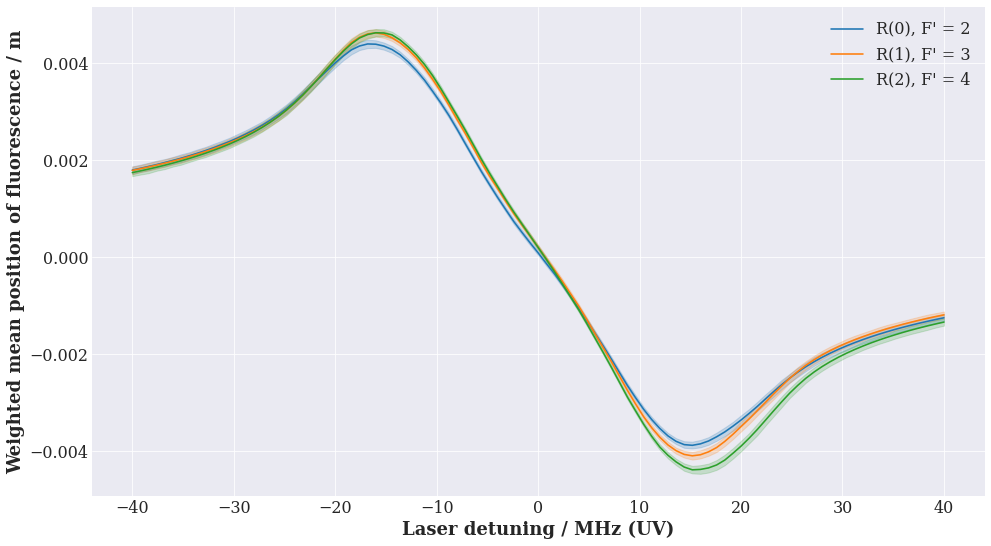

In [12]:
ax = sns.lineplot(data = df_pos_R0F2, x = 'detuning', y = 'x_mean', label = "R(0), F' = 2")
ax = sns.lineplot(data = df_pos_R1F3, x = 'detuning', y = 'x_mean', label = "R(1), F' = 3")
ax = sns.lineplot(data = df_pos_R2F4, x = 'detuning', y = 'x_mean', label = "R(2), F' = 4")
ax.set_ylabel('Weighted mean position of fluorescence / m')
ax.set_xlabel('Laser detuning / MHz (UV)')

### Size of fluorescence cloud from standard deviation

Text(0.5, 0, 'Laser detuning / MHz (UV)')

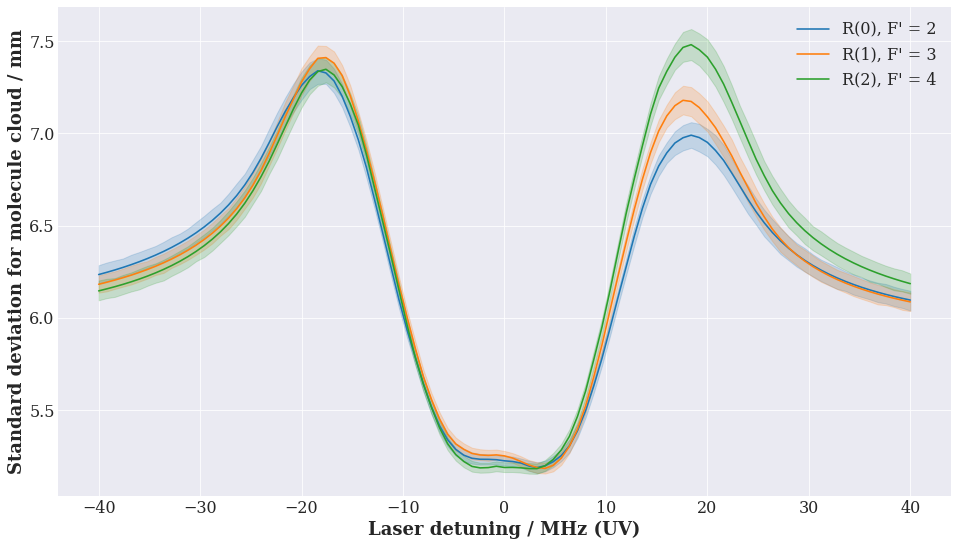

In [13]:
ax = sns.lineplot(data = df_pos_R0F2, x = 'detuning', y = 'x_std', label = "R(0), F' = 2")
ax = sns.lineplot(data = df_pos_R1F3, x = 'detuning', y = 'x_std', label = "R(1), F' = 3")
ax = sns.lineplot(data = df_pos_R2F4, x = 'detuning', y = 'x_std', label = "R(2), F' = 4")
ax.set_ylabel('Standard deviation for molecule cloud / mm')
ax.set_xlabel('Laser detuning / MHz (UV)')

## Plot signal size as function of position for some detunings

In [14]:
df_R0F2_raw

,index,x,y,x_mm,y_mm,vx,vy,vz,doppler,delta_t,laser_detuning,detuning,n_photons,detuning_MHz,norm_signal
0,2787,0.002494,0.002068,2.493827,2.067809,1.549932,0.664743,199.945363,3.584288e+07,0.000023,-2.513274e+08,-2.154845e+08,0.056800,-40.0,0.029583
1,2787,0.002494,0.002068,2.493827,2.067809,1.549932,0.664743,199.945363,3.584288e+07,0.000023,-2.463009e+08,-2.104580e+08,0.059625,-39.2,0.031055
2,2787,0.002494,0.002068,2.493827,2.067809,1.549932,0.664743,199.945363,3.584288e+07,0.000023,-2.412743e+08,-2.054314e+08,0.062669,-38.4,0.032640
3,2787,0.002494,0.002068,2.493827,2.067809,1.549932,0.664743,199.945363,3.584288e+07,0.000023,-2.362478e+08,-2.004049e+08,0.065955,-37.6,0.034351
4,2787,0.002494,0.002068,2.493827,2.067809,1.549932,0.664743,199.945363,3.584288e+07,0.000023,-2.312212e+08,-1.953783e+08,0.069508,-36.8,0.036202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009995,9730,-0.003788,-0.000531,-3.788165,-0.531027,-0.957233,-0.107236,158.341609,-2.213645e+07,0.000029,2.312212e+08,2.090848e+08,0.158735,36.8,0.082674
1009996,9730,-0.003788,-0.000531,-3.788165,-0.531027,-0.957233,-0.107236,158.341609,-2.213645e+07,0.000029,2.362478e+08,2.141113e+08,0.151378,37.6,0.078843
1009997,9730,-0.003788,-0.000531,-3.788165,-0.531027,-0.957233,-0.107236,158.341609,-2.213645e+07,0.000029,2.412743e+08,2.191379e+08,0.144519,38.4,0.075270
1009998,9730,-0.003788,-0.000531,-3.788165,-0.531027,-0.957233,-0.107236,158.341609,-2.213645e+07,0.000029,2.463009e+08,2.241644e+08,0.138116,39.2,0.071935


In [25]:
data = df_R0F2_raw.query('detuning_MHz==0.')
sig_mean_x = np.sum(data.x_mm * data.n_photons)/np.sum(data.n_photons)
sig_std = np.sqrt(np.sum(data.n_photons * (data.x_mm - sig_mean_x)**2)/np.sum(data.n_photons))

Center from fit: 0.092+/-0.135 mm
Sigma from fit: 5.847+/-0.135 mm


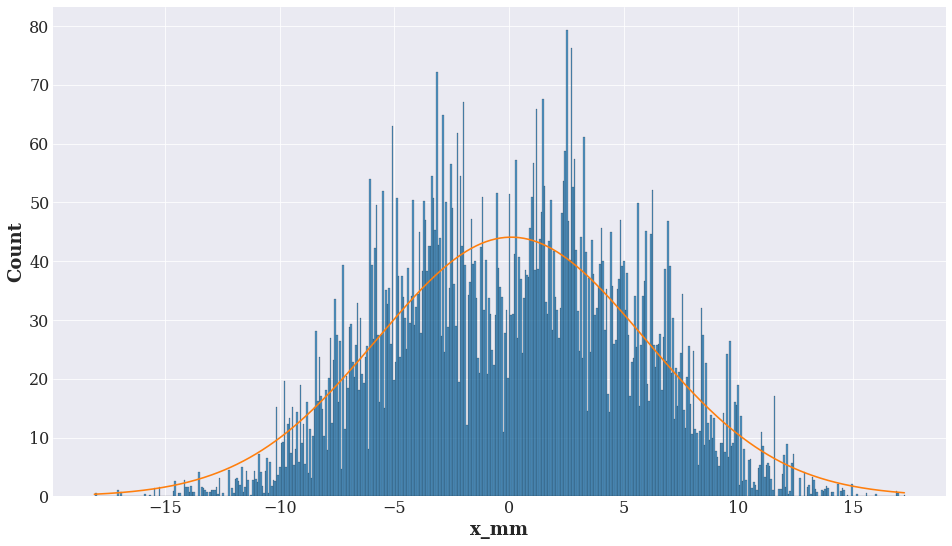

In [26]:
ax = sns.histplot(data = data, x = 'x_mm', weights = 'n_photons', bins = 512)

# Fit a gaussian to the counts data
counts, bin_edges = np.histogram(data.x_mm, weights=data.n_photons, bins = 512)
x_fit = bin_edges[:-1]+np.diff(bin_edges)/2
model = lmfit.models.GaussianModel()
params = model.guess(counts, x = x_fit)
result = model.fit(counts, x = x_fit, params = params)

ax.plot(x_fit, result.best_fit, c = 'C1', label = 'Gaussian fit')
print(f"Center from fit: {result.params['center'].value:.3f}+/-{result.params['center'].stderr:.3f} mm")
print(f"Sigma from fit: {result.params['sigma'].value:.3f}+/-{result.params['sigma'].stderr:.3f} mm")

In [17]:
result.params

name,value,standard error,relative error,initial value,min,max,vary,expression
amplitude,646.070276,12.8943657,(2.00%),1544.7569770819784,-inf,inf,True,
center,0.09155930,0.13467407,(147.09%),0.12199171314888406,-inf,inf,True,
sigma,5.84664112,0.13490383,(2.31%),6.496048964467031,0.00000000,inf,True,
fwhm,13.7677874,0.31767424,(2.31%),15.297026022506254,-inf,inf,False,2.3548200*sigma
height,44.0842454,0.87964801,(2.00%),94.86826604126338,-inf,inf,False,"0.3989423*amplitude/max(1e-15, sigma)"


### Center and size using fitting
Instead of calculating the mean and standard deviation from the fitting directly, fit a Gaussian to the simulated data. This is closer to what is actually done in the data analysis.

In [31]:
def calculate_xpos_params(df: pd.DataFrame) -> pd.DataFrame:
    """
    Determines the mean and standard deviation for a dataset by fitting a gaussian
    for each detuning
    """
    result_dict = dict(detuning=[], x_mean = [], x_std = [], amp = [])

    for detuning, data in df.groupby('detuning_MHz'):
        result_dict['detuning'].append(detuning)
        
        # Fit a gaussian to the counts data
        counts, bin_edges = np.histogram(data.x_mm, weights=data.n_photons, bins = 512)
        x_fit = bin_edges[:-1]+np.diff(bin_edges)/2
        model = lmfit.models.GaussianModel()
        params = model.guess(counts, x = x_fit)
        result = model.fit(counts, x = x_fit, params = params)

        result_dict['x_mean'].append(result.params['center'].value)
        result_dict['x_std'].append(result.params['sigma'].value)
        result_dict['amp'].append(result.params['amplitude'].value/len(data))

    return pd.DataFrame(result_dict)
    

def bootstrap_xpos_params(df:pd.DataFrame, n_bs = 2) -> pd.DataFrame:
    df_bs = pd.DataFrame()
    
    for n in tqdm(range(n_bs)):
        # Choose trajectories randomly
        traj_idxs = np.random.choice(df['index'].unique(), 1000, replace = False)
        
        df_pos = calculate_xpos_params(df[df['index'].isin(traj_idxs)])
        
        df_bs = pd.concat([df_bs, df_pos])
        
    return df_bs.reset_index(drop = True)

def aggregate_bootstrap(df: pd.DataFrame) -> pd.DataFrame:
    return df.groupby('detuning').agg([np.mean, sem]).reset_index()

In [36]:
%%time
df_pos_R0F2 = bootstrap_xpos_params(df_R0F2_raw, n_bs = 100)
df_pos_R1F3 = bootstrap_xpos_params(df_R1F3_raw, n_bs = 100)
df_pos_R2F4 = bootstrap_xpos_params(df_R2F4_raw, n_bs = 100)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:59<00:00,  1.19s/it]

Wall time: 5min 52s


Text(0.5, 0, 'Laser detuning / MHz (UV)')

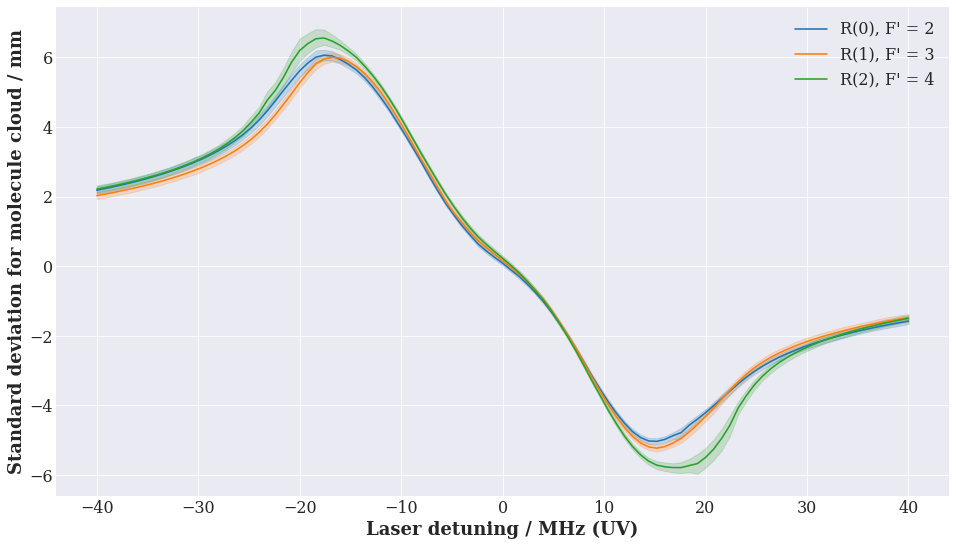

In [37]:
ax = sns.lineplot(data = df_pos_R0F2, x = 'detuning', y = 'x_mean', label = "R(0), F' = 2")
ax = sns.lineplot(data = df_pos_R1F3, x = 'detuning', y = 'x_mean', label = "R(1), F' = 3")
ax = sns.lineplot(data = df_pos_R2F4, x = 'detuning', y = 'x_mean', label = "R(2), F' = 4")
ax.set_ylabel('Standard deviation for molecule cloud / mm')
ax.set_xlabel('Laser detuning / MHz (UV)')
# ax.set_ylim([4,8])

Text(0.5, 0, 'Laser detuning / MHz (UV)')

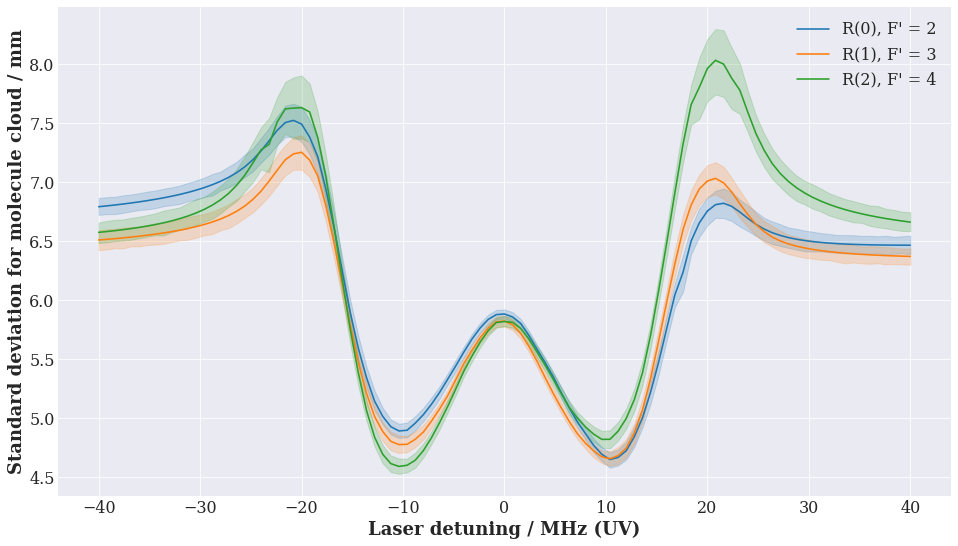

In [38]:
ax = sns.lineplot(data = df_pos_R0F2, x = 'detuning', y = 'x_std', label = "R(0), F' = 2")
ax = sns.lineplot(data = df_pos_R1F3, x = 'detuning', y = 'x_std', label = "R(1), F' = 3")
ax = sns.lineplot(data = df_pos_R2F4, x = 'detuning', y = 'x_std', label = "R(2), F' = 4")
ax.set_ylabel('Standard deviation for molecule cloud / mm')
ax.set_xlabel('Laser detuning / MHz (UV)')
# ax.set_ylim([4,8])

Numbers of photons at resonance:
R(0), F' = 2: 0.906
R(1), F' = 3: 0.970
R(2), F' = 4: 0.955


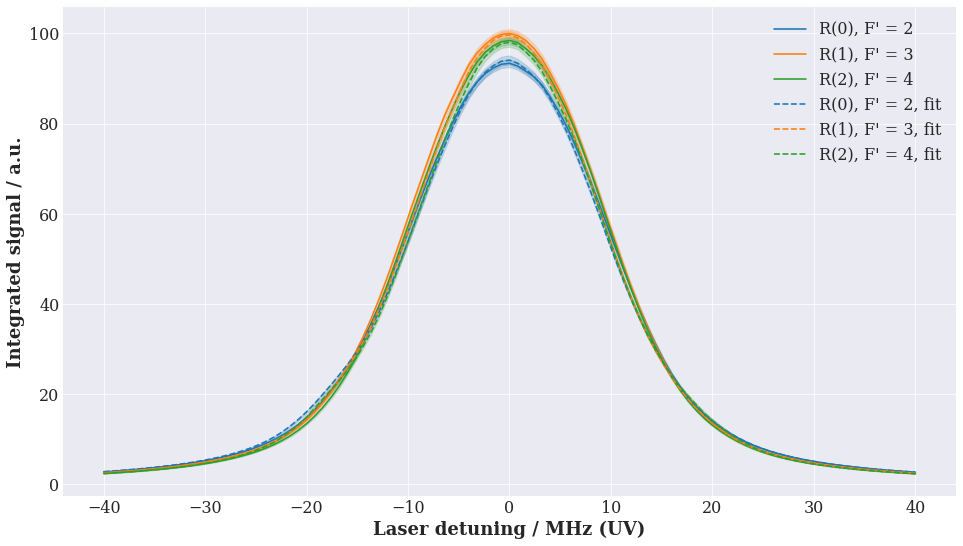

In [45]:
fig, ax = plt.subplots()
f = 1/.97*100
ax.plot(df_R0F2.detuning_MHz, df_R0F2.n_photons*f, color = 'C0', label = "R(0), F' = 2")
ax.fill_between(df_R0F2.detuning_MHz, df_R0F2.n_photons*f-df_R0F2.n_photons_sem*f, df_R0F2.n_photons*f+df_R0F2.n_photons_sem*f, color = 'C0', alpha = 0.2)
ax.plot(df_R1F3.detuning_MHz, df_R1F3.n_photons*f, color = 'C1', label = "R(1), F' = 3")
ax.fill_between(df_R1F3.detuning_MHz, df_R1F3.n_photons*f-df_R1F3.n_photons_sem*f, df_R1F3.n_photons*f+df_R1F3.n_photons_sem*f, color = 'C1', alpha = 0.2)
ax.plot(df_R2F4.detuning_MHz, df_R2F4.n_photons*f, color = 'C2', label = "R(2), F' = 4")
ax.fill_between(df_R2F4.detuning_MHz, df_R2F4.n_photons*f-df_R2F4.n_photons_sem*f, df_R2F4.n_photons*f+df_R2F4.n_photons_sem*f, color = 'C2', alpha = 0.2)
ax.set_xlabel('Laser detuning / MHz')
ax.set_ylabel('Mean number of photons\nper molecule')


ax = sns.lineplot(data = df_pos_R0F2, x = 'detuning', y = 'amp', label = "R(0), F' = 2, fit", ax = ax, ls = '--')
ax = sns.lineplot(data = df_pos_R1F3, x = 'detuning', y = 'amp', label = "R(1), F' = 3, fit", ax = ax, ls = '--')
ax = sns.lineplot(data = df_pos_R2F4, x = 'detuning', y = 'amp', label = "R(2), F' = 4, fit", ax = ax, ls = '--')
ax.set_ylabel('Integrated signal / a.u.')
ax.set_xlabel('Laser detuning / MHz (UV)')

ax.legend()
print("Numbers of photons at resonance:")
print(f"R(0), F' = 2: {df_R0F2.n_photons.max():.3f}")
print(f"R(1), F' = 3: {df_R1F3.n_photons.max():.3f}")
print(f"R(2), F' = 4: {df_R2F4.n_photons.max():.3f}")